# Autoencoders

Autoencoders are ANNs capable of learning efficient representation of the input data - *codings* without supervision (unsupervised learning).

Autoencoders can be used as a dimensionality reduction technique, feature detectors (they can be used for unsupervised pretraining of deep neural networks).

Autoencoders are **generative** models.

**Codings** are byproducts (side effects, consequences) of the autoencoder's attempt to learn the *identity function* under some constraints (learn to copy inputs to outputs with predefined constraints).

The autoencoder observes the inputs, converts them into an efficient internal representation, and generates things that look close to the inputs.

An autoencoder has two parts: **encoder** (recognition network) and **decoder** (generative network).

Autoencoder typically has the same architecture as MLP but *the number of neurons in the output layer must be equal to the number of inputs*.

The output of autoencoder is called **reconstructions**, and the cost function used in autoencoders is typically called **reconstruction loss**.

The autoencoder is said to be *undercomplete* because the internal representation has a lower dimensionality than the input data. As a result, autoencoders cannot just copy their inputs to their outputs. They must find a best way to do that by learning the most important features and dropping unimportant ones.

In [1]:
%run 'init.py'

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


## PCA with an Undercomplete Linear Autoencoder

In [2]:
import numpy.random as rnd

rnd.seed(42)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)
data.shape

(200, 3)

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.fit_transform(data[100:])

If the autoencoder uses linear activations and the cost function is MSE. Then, the autoencoder actually performs PCA (Principal Component Analysis).

In [4]:
n_inputs = 3 # The inputs dimension - 3D
n_hidden = 2 # The codings dimension - 2D
n_outputs = n_inputs # The number of input neurons and output neurons are equal

learning_rate = 1e-3

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

# Compute the reconstruction loss - MSE in this case
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

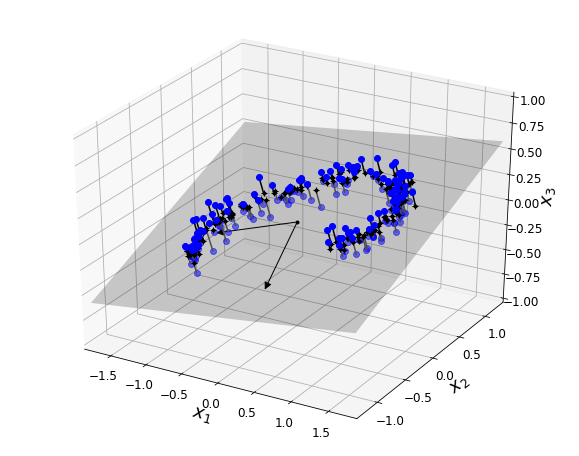

In [5]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

X = data
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
X3D_inv = pca.inverse_transform(X2D)

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()
plt.clf()

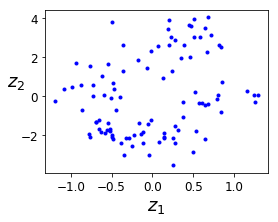

In [6]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()
plt.clf()

## Stacked Autoencoders

### Simple Architecture

Autoencoders may have multiple hidden layers like regular neural networks. They are called **stacked autoencoders** or **deep autoencoders**.

Adding hidden layers allows autoencoders to learn more complex codings.

However, we should not make the structure of the autoencoders too complex as they may overfit the training set. It reconstructs the training data perfectly, but it did not learn any useful data representation. Consequently, it cannot generalize well to new instances.

The architecture of stacked autoencoders is usually symmetrical with regards to the coding layer (the central layer) as shown in the following figure.

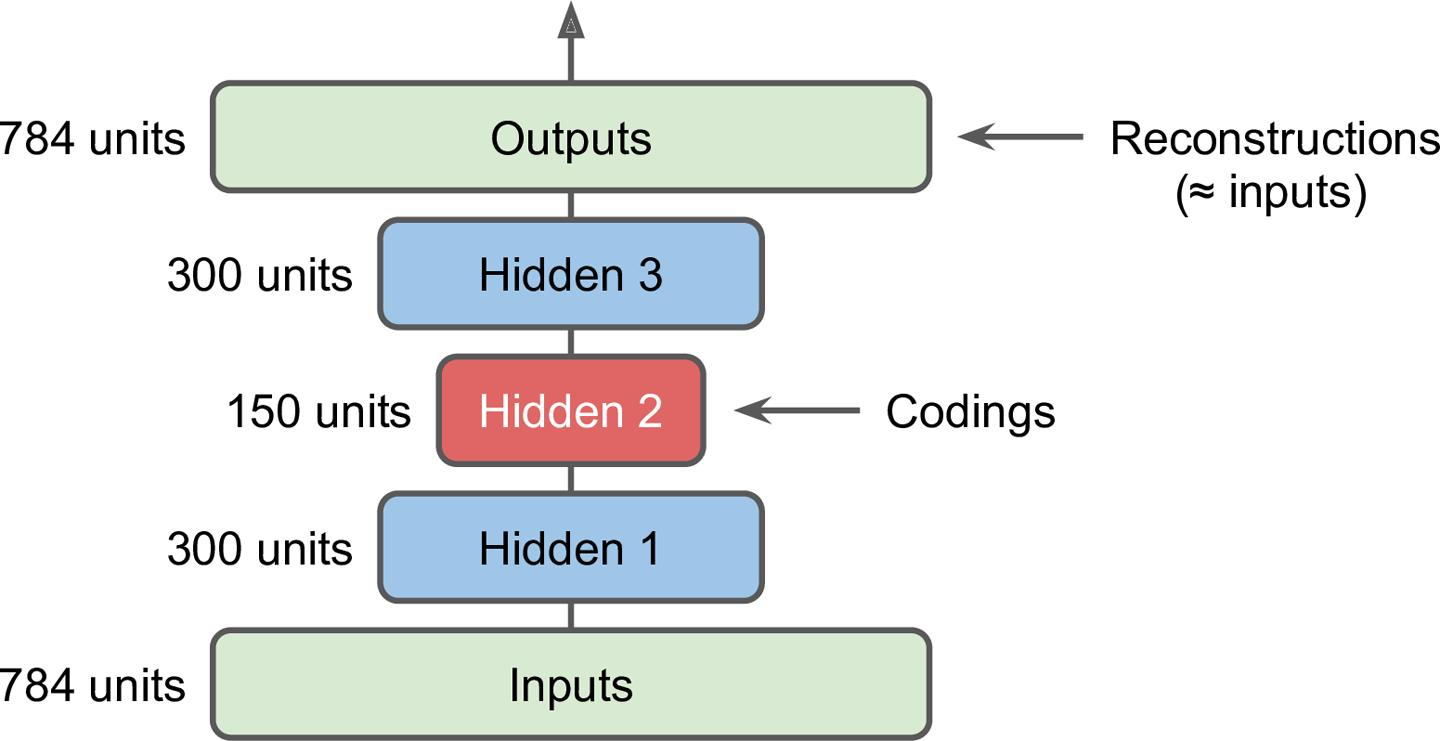

In [7]:
show_image('./images/img2917.jpg', width='70%')

We can implement autoencoders very much like MLP. We can improve the training process by using initialization techniques, different activations and regularization schemes.

In [8]:
from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150 # coding layer
n_hidden3 = 300
n_outputs = n_inputs

learning_rate = 1e-3

X = tf.placeholder(tf.float32, [None, n_inputs])
training = tf.placeholder_with_default(False, shape=())

he_int = tf.contrib.layers.variance_scaling_initializer()
dense_layer = partial(tf.layers.dense,
                      activation=tf.nn.elu,
                      kernel_initializer=he_int)

dropout_layer = partial(tf.layers.dropout, training=training)

hidden1 = dense_layer(X, n_hidden1)
hidden2 = dense_layer(hidden1, n_hidden2)
hidden2_drop = dropout_layer(hidden2)

codings = dense_layer(hidden2_drop, n_hidden2)

hidden3 = dense_layer(codings, n_hidden3)
hidden3_drop = dropout_layer(hidden3)
outputs = dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
saver = tf.train.Saver()

n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        mse_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print(epoch, "Loss:", mse_train)
    saver.save(sess, './models/basic-autoencoder/basic.ckpt')

0 Loss: 0.0353969
1 Loss: 0.0257518
2 Loss: 0.0241094
3 Loss: 0.0214034
4 Loss: 0.0200591
5 Loss: 0.0168342
6 Loss: 0.0158268
7 Loss: 0.0150415
8 Loss: 0.0146191
9 Loss: 0.0140926


In [9]:
def show_reconstructed_digits(X, outputs, model_path=None, n_test_digits=2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./models/basic-autoencoder/basic.ckpt


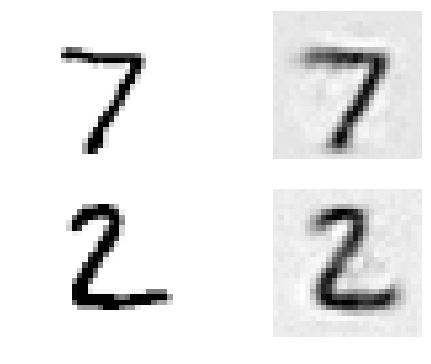

In [10]:
show_reconstructed_digits(X, outputs, './models/basic-autoencoder/basic.ckpt')
plt.show()
plt.clf()

### Tying weights

When the structure of the autoencoder is symmetrical, we can *tie the weights* of the decoder layers to the weights of the encoder layers. This action reduces the number of model parameter. This speeds up the training process and avoids overfitting problem.

If the autoencoder has N layers (excluding the input layer), $W_L$ is the connection weights of the $L^{th}$ layer, then the decoder layer weights can be defined as: $W_{N-L+1} = W_L^T$ ($L = 1, 2,...,N/2$)

In [11]:
l2_reg = 0.001
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, [None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32)
weights2 = tf.Variable(weights2_init, dtype=tf.float32)
weights3 = tf.transpose(weights2)
weights4 = tf.transpose(weights1)

biases1 = tf.Variable(tf.zeros(n_hidden1))
biases2 = tf.Variable(tf.zeros(n_hidden2))
biases3 = tf.Variable(tf.zeros(n_hidden3))
biases4 = tf.Variable(tf.zeros(n_outputs))

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

saver = tf.train.Saver()

n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        mse_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print(epoch, "Loss:", mse_train)
    saver.save(sess, './models/tie-weights-autoencoder/tie-weights.ckpt')

0 Loss: 0.0242777
1 Loss: 0.026095
2 Loss: 0.0252773
3 Loss: 0.0255363
4 Loss: 0.0246664
5 Loss: 0.0266097
6 Loss: 0.0248454
7 Loss: 0.0253854
8 Loss: 0.0255203
9 Loss: 0.026309


INFO:tensorflow:Restoring parameters from ./models/tie-weights-autoencoder/tie-weights.ckpt


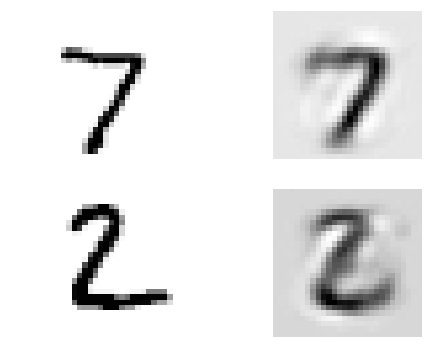

In [12]:
show_reconstructed_digits(X, outputs, './models/tie-weights-autoencoder/tie-weights.ckpt')
plt.show()
plt.clf()

Notes:
- `weights3` and `weights4` are not variables, they are the transpose of `weights2` and `weights1`
- We cannot use regularization on `weights3` and `weights4`
- Biases are never tied and regularized

### Training one autoencoder at a time using multiple graphs

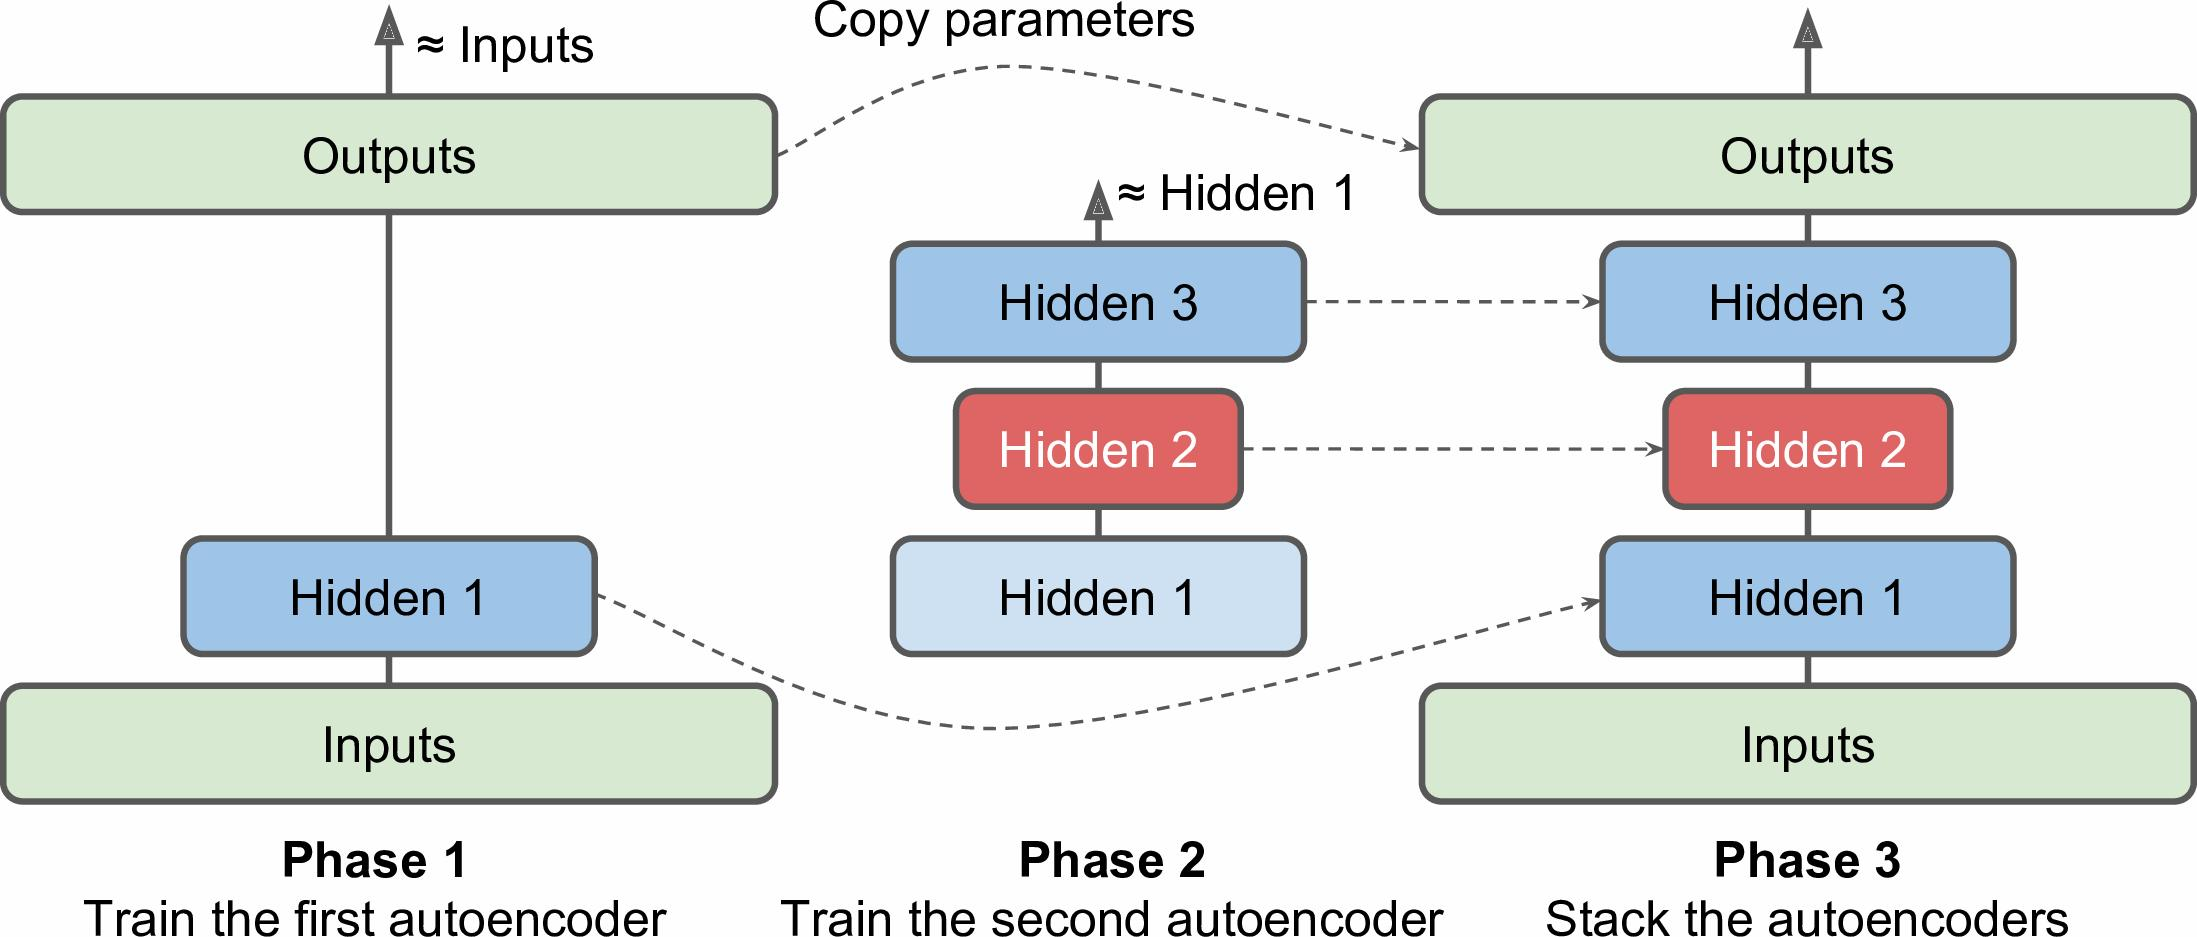

In [13]:
show_image('./images/img2926.jpg', width='70%')

Training the whole stacked autoencoder may be cumbersome. It's often faster to train one shallow autoencoder at a time, then stack all of them into a single stacked autoencoder.

In the example shown in a bove figure, there're three phases when training the autoencoder. 
- In the first phase, the first autoencoder learns to reconstruct the inputs
- In the second phase, the second autoencoder learns to reconstruct the output of the first autoencoder's hidden layer
- In the final phase, we stack the hidden layers of each autoencoder, then the output layers in reverse order

To implement multi-phase training process, we can use a different graph for each phase. After training an autoencoder, we just run the training set through it and get the output of the hidden layer. This output will be the training set for the next autoencoder. After all autoencoders are trained, we copy the weights and biases from each autoencoder and use them to build the stacked autoencoder.

In [21]:
import sys

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size, 
                      learning_rate=1e-3, l2_reg=5e-4, activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        n_inputs = X_train.shape[1]
        X = tf.placeholder(tf.float32, [None, n_inputs])
        
        dense_layer = partial(tf.layers.dense,
                              activation=activation,
                              kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                              kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))
        hidden = dense_layer(X, n_neurons, name="hidden")
        outputs = dense_layer(hidden, n_inputs, activation=None, name="outputs")
        
        mse = tf.reduce_mean(tf.square(outputs - X))
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([mse] + reg_losses)
        
        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)
        init = tf.global_variables_initializer()
        
    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            mse_train = mse.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", mse_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [22]:
# Training two autoencoders. The first one is trained on the training data,
# and the second one is trained on the previous autoencoder's hidden layer output.
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images,
                                                  n_neurons=300,
                                                  n_epochs=4,
                                                  batch_size=150)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output,
                                      n_neurons=150,
                                      n_epochs=4,
                                      batch_size=150)

0 Train MSE: 0.0168994
1 Train MSE: 0.0179481
2 Train MSE: 0.019156
3 Train MSE: 0.0178266
0 Train MSE: 0.00504019
1 Train MSE: 0.00324106
2 Train MSE: 0.00357416
3 Train MSE: 0.00364868


In [23]:
reset_graph()

n_inputs = 784

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

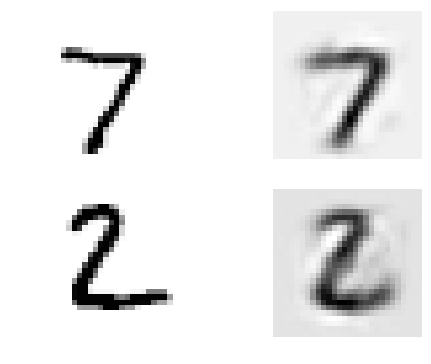

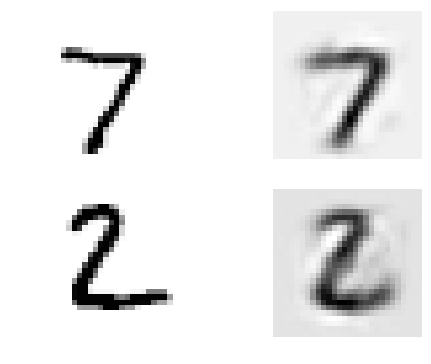

In [25]:
show_reconstructed_digits(X, outputs)
plt.show()
plt.clf()

### Training one autoencoder at a time using a single graph

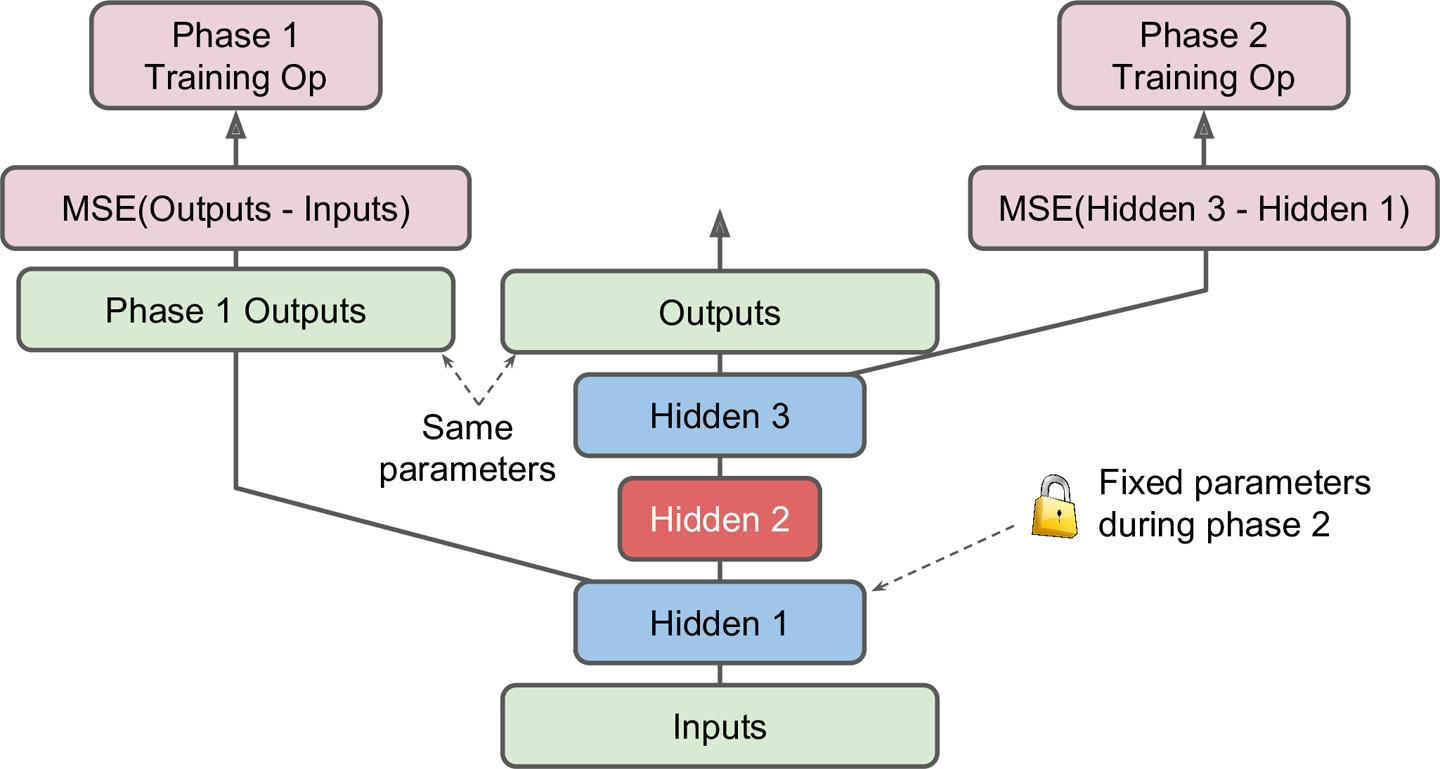

In [26]:
show_image('./images/img2932.jpg', width='70%')